# TODO: clean up this file; make final fig...

In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# import mcspace.visualization as vis
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import mcspace.vis_tools as vis
# from mcspace.fig_utils import *''
import matplotlib.colors as mcolors

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
pwd

'C:\\Users\\Gary2\\Partners HealthCare Dropbox\\Gurdip Uppal\\research_bwh\\MCSPACE_FINAL\\MCSPACE\\mcspace\\paper\\figures'

In [4]:
rootpath = Path("../../")
basepath = Path("./")

In [5]:
runpath = rootpath / "paper" / "human_runs" / "runs"

In [6]:
treepath = rootpath / "data" / "human_experiments" / "human_otus_tree" / "output" # *** rename this
treefile = "newick_tree_query_reads.nhx"

In [7]:
outpath = basepath / "figs_human_results"
outpath.mkdir(exist_ok=True, parents=True)

# Load best model results

In [8]:
respath = get_min_loss_path(runpath, np.arange(10))

0
1
2
3
4
5
6
7
8
9
3


In [9]:
model = torch.load(respath / MODEL_FILE)
data = pickle_load(respath / DATA_FILE)

taxonomy_temp = pickle_load(respath / "taxonomy.pkl")

times = list(data['count_data'].keys())
subjects = list(data['count_data'][1].keys())
num_otus = data['count_data'][times[0]][subjects[0]].shape[1]
num_times = len(times)
num_subjects = len(subjects)

In [10]:
print(times)
print(subjects)
print(num_otus)

[1, 2, 3, 4, 5]
['H11']
58


In [11]:
taxonomy_temp.head()

,Kingdom,Phylum,Class,Order,Family,Genus
Otu,,,,,,
Otu121,Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,na
Otu14,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,na
Otu150,Bacteria,Firmicutes,Clostridia,Oscillospirales,Oscillospiraceae,uncultured
Otu37,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
Otu6,Bacteria,Actinobacteriota,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium


### load final taxonomy

In [12]:
taxfile =  rootpath / "data" / "human_experiments" / "gappa_taxonomy" / "human_taxonomy.csv"
finaltax = pd.read_csv(taxfile, index_col=0)

In [13]:
finaltax.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Otu,,,,,,,
Otu1720,Bacteria,Firmicutes,Clostridia,Clostridiales,Oscillospiraceae,Oscillibacter,Oscillibacter valericigenes
Otu3529,Bacteria,Proteobacteria,Gammaproteobacteria,Thiotrichales,Thiotrichaceae,Thiothrix,na
Otu3620,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Parabacteroides,na
Otu93,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,na
Otu3524,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans


In [14]:
taxlist = list(taxonomy_temp.index)
taxonomy = finaltax.loc[taxlist,:]

In [15]:
taxonomy.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Otu,,,,,,,
Otu121,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na
Otu14,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans
Otu150,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,na
Otu37,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus
Otu6,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,na


# Get summary results

In [16]:
thetadf, betadf, pertsdf = get_posterior_summary_data(model, data, taxonomy, times, subjects)

In [17]:
betadf

,Time,Subject,Assemblage,Value,log10Value
0,1,H11,A1,0.005059,-2.295939
1,1,H11,A2,0.007040,-2.152433
2,1,H11,A3,0.027747,-1.556781
3,1,H11,A4,0.012340,-1.908697
4,1,H11,A5,0.060081,-1.221265
...,...,...,...,...,...
340,5,H11,A65,0.006997,-2.155115
341,5,H11,A66,0.005289,-2.276625
342,5,H11,A67,0.009562,-2.019464
343,5,H11,A68,0.001263,-2.898614


# Render figure

### methods (move to utils)

In [18]:
def get_abundance_order(betadf):
    betadf_drop = betadf[['Assemblage', 'Value']]
    aveval = betadf_drop.groupby('Assemblage').mean()
    beta_order = aveval.sort_values(by='Value', ascending=False).index
    return beta_order

In [19]:
# vs plot_proportions_timepoint_subjects...?
def plot_subject_proportions_timeseries(ax, betadf, subj, order, logscale=True, vmin=-2, vmax=0, cmap='Blues',
                                   linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=True,
                                   square=False, cbar=False):
    if logscale is True:
        val = 'log10Value'
    else:
        val = 'Value'
        
    betasub = betadf.loc[(betadf['Subject'] == subj),:]
    betamatrix = betasub.pivot(index='Time', columns='Assemblage', values=val)
    ax=sns.heatmap(betamatrix.loc[:,order], ax=ax, cmap=cmap, square=square, vmin=vmin, vmax=vmax, cbar=cbar,
               linewidth=linewidth, linecolor=linecolor, xticklabels=xticklabels, yticklabels=yticklabels)
    return ax

In [20]:
def get_lowest_level(otu, taxonomy):
    taxonomies = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Domain']
    for level in taxonomies:
        levelid = taxonomy.loc[otu,level]
        if levelid != 'na':
            return levelid, level

In [21]:
def plot_phylo_tree(ax, tree, taxonomy, fontsize=16, text_len=41):            
    TEXT_LEN=text_len
    prefix_taxa = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****',
                   'Class': '*****', 'Phylum': '******', 'Domain': '*******'}

    Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False)
    taxa_order = []

    for text in ax.texts:
        taxonname = str(text._text).replace(' ','').capitalize()
        otu_name = taxonname
        taxa_order.append(otu_name)
        name, level = get_lowest_level(otu_name, taxonomy)
        prefix = prefix_taxa[level]
        taxonname = ' ' + prefix + ' ' + name + ' ' + otu_name
        text._text = taxonname
        text._text = text._text + '- ' * (TEXT_LEN - len(text._text))
        text.set_fontsize(fontsize)
    
    ax = remove_border(ax)
    return ax, taxa_order

In [22]:
def plot_assemblages(ax, thetadf, otu_order, beta_order, cmap=None, logscale=True, vmin=-2, vmax=0,
               linecolor ='#e6e6e6', linewidth=0.5, xticklabels=True, yticklabels=False,
               square=False, cbar=False):
    
    # reset multiindex
    thetatemp = thetadf.reset_index()
    thetatemp=thetatemp.set_index('Otu')
    
    if logscale is True:
        thetaplot = np.log10(thetatemp.loc[otu_order,:][beta_order] + 1e-20)
    else:
        thetaplot = thetatemp.loc[otu_order,:][beta_order]
    
    if cmap is None:
        green = sns.light_palette("green", reverse=False, as_cmap=True)
        green.set_under('white')
        cmap=green
    cbar_kws = dict(extend='min')

    ax=sns.heatmap(thetaplot, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, linecolor=linecolor, linewidth=linewidth,
               xticklabels=xticklabels, yticklabels=yticklabels, square=square, cbar=cbar, cbar_kws=cbar_kws)
    return ax

In [23]:
def remove_border(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax

In [24]:
def add_border(ax, color='black'):
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_color(color)
    return ax

In [25]:
# TODO : fix tree names so standardized?...
def get_pruned_tree(treepath, treefile, taxonomy, temppath=Path("./_tmp")):
    tree = ete3.Tree((treepath / treefile).as_posix())
    print("original tree size:", len(tree))
    taxaids = list(taxonomy.index)
    taxaids = [idx.upper() for idx in taxaids] # HOW TO KNOW IF NEEDED?...
    tree.prune(taxaids, True)
    print("pruned tree size:", len(tree))
    
    treeout = "tree.nhx"
    temppath.mkdir(exist_ok=True, parents=True)
    tree.write(outfile=(temppath / treeout).as_posix())
    phylo_tree = Phylo.read(temppath / treeout, format='newick')
    return phylo_tree

## settings

In [26]:
taxonomy.rename(columns={"Kingdom":"Domain"}, inplace=True)

In [27]:
fontsize = 12
subfontsize = 8

In [28]:
nsubj = len(subjects)
ntime = len(times)
notus, ncomm = thetadf.shape

## plot

In [29]:
ncomm_max = 120
notu_max = 120

tree_ratio = 0.1
gap_ratio = 0.15

original tree size: 3923
pruned tree size: 58


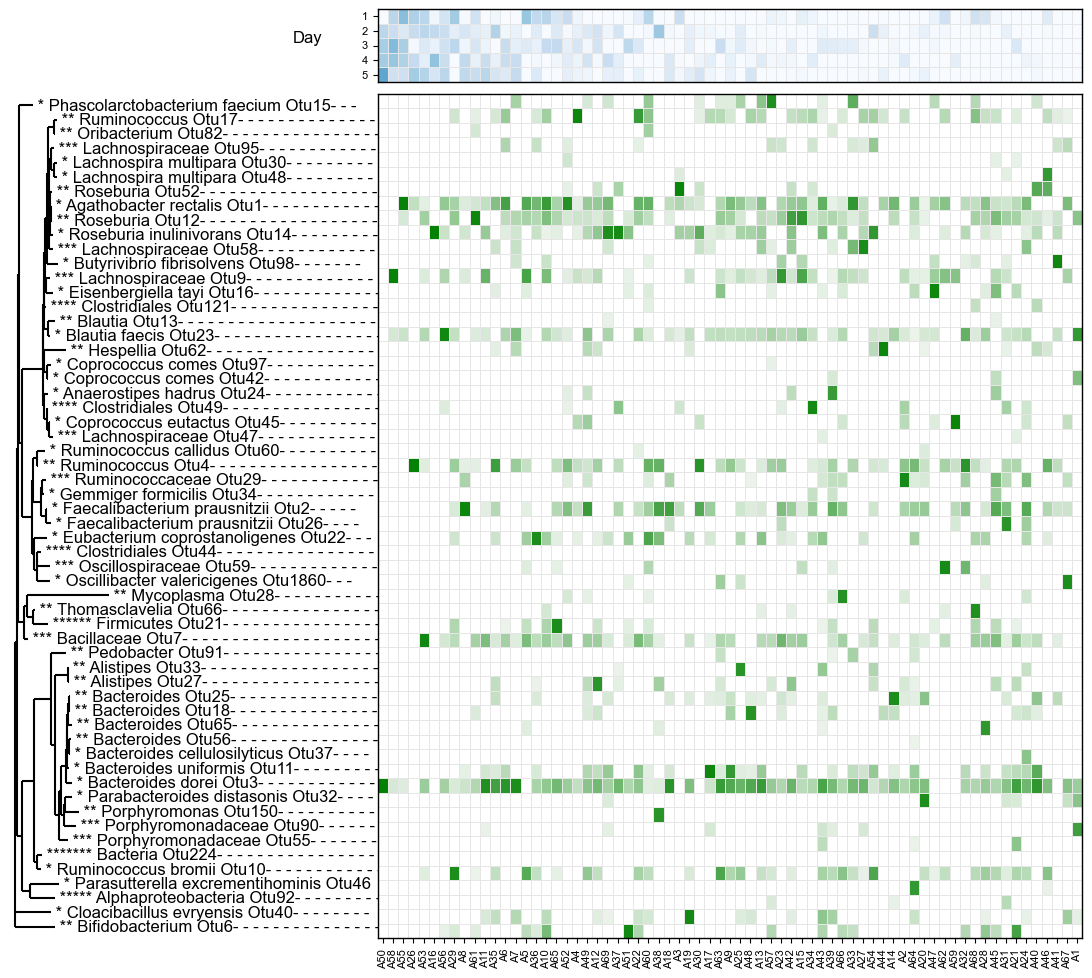

In [30]:
scale=2

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max]
hratios.append(notus/notu_max)
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max)) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=1+2,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_tree = fig.add_subplot(gs[1,0])
ax_theta = fig.add_subplot(gs[1,2])

# plot assemlage proportions
beta_order = get_abundance_order(betadf)

ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=50, ha='left', fontsize=fontsize)
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize)

# plot assemblages
ax_theta=plot_assemblages(ax_theta, thetadf, otu_order, beta_order) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)

## add variance over time

In [31]:
# thetadf

In [32]:
betadf

,Time,Subject,Assemblage,Value,log10Value
0,1,H11,A1,0.005059,-2.295939
1,1,H11,A2,0.007040,-2.152433
2,1,H11,A3,0.027747,-1.556781
3,1,H11,A4,0.012340,-1.908697
4,1,H11,A5,0.060081,-1.221265
...,...,...,...,...,...
340,5,H11,A65,0.006997,-2.155115
341,5,H11,A66,0.005289,-2.276625
342,5,H11,A67,0.009562,-2.019464
343,5,H11,A68,0.001263,-2.898614


In [33]:
def get_subj_averaged_assemblage_proportions(betadf):
    subjave = betadf.loc[:,['Time','Assemblage','Value']].groupby(by=['Time','Assemblage']).mean()
    subjave.reset_index(inplace=True)
    betamat = subjave.pivot(index='Time', columns='Assemblage', values='Value')
    return betamat

In [34]:
avebeta = get_subj_averaged_assemblage_proportions(betadf)

In [35]:
betadf

,Time,Subject,Assemblage,Value,log10Value
0,1,H11,A1,0.005059,-2.295939
1,1,H11,A2,0.007040,-2.152433
2,1,H11,A3,0.027747,-1.556781
3,1,H11,A4,0.012340,-1.908697
4,1,H11,A5,0.060081,-1.221265
...,...,...,...,...,...
340,5,H11,A65,0.006997,-2.155115
341,5,H11,A66,0.005289,-2.276625
342,5,H11,A67,0.009562,-2.019464
343,5,H11,A68,0.001263,-2.898614


In [36]:
avebeta

Assemblage,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,...,A63,A64,A65,A66,A67,A68,A69,A7,A8,A9
Time,,,,,,,,,,,,,,,,,,,,,
1,0.005059,0.038667,0.005746,0.005956,0.006132,0.004469,0.015021,0.012152,0.008859,0.002914,...,0.003820,0.003594,0.021543,0.010140,0.002687,0.024732,0.005000,0.007005,0.010584,0.004020
2,0.004458,0.007871,0.014884,0.023408,0.010758,0.010359,0.008145,0.033044,0.012041,0.011211,...,0.010414,0.011598,0.019040,0.010177,0.006965,0.010801,0.012377,0.013916,0.021357,0.010281
3,0.002134,0.031895,0.013156,0.023314,0.008020,0.011524,0.008605,0.013971,0.006989,0.007263,...,0.028289,0.008047,0.032390,0.015907,0.002613,0.003518,0.007365,0.015661,0.012205,0.011976
4,0.002479,0.008417,0.029185,0.010999,0.017430,0.010845,0.006790,0.065234,0.015950,0.019785,...,0.006679,0.009486,0.012033,0.006041,0.007617,0.000926,0.028310,0.029191,0.032954,0.014515
5,0.000875,0.005465,0.037263,0.006474,0.010001,0.008290,0.011221,0.021790,0.012485,0.020045,...,0.005686,0.011136,0.006997,0.005289,0.009562,0.001263,0.014691,0.031256,0.034153,0.013979


### add stats

In [37]:
beta = avebeta.T
beta['Min'] = beta.min(axis=1)
beta['Max'] = beta.max(axis=1)
beta['Mean'] = beta.mean(axis=1)
beta['Variance of log'] = np.log(beta).var(axis=1)
beta = beta.T

In [38]:
beta

Assemblage,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,...,A63,A64,A65,A66,A67,A68,A69,A7,A8,A9
Time,,,,,,,,,,,,,,,,,,,,,
1,0.005059,0.038667,0.005746,0.005956,0.006132,0.004469,0.015021,0.012152,0.008859,0.002914,...,0.003820,0.003594,0.021543,0.010140,0.002687,0.024732,0.005000,0.007005,0.010584,0.004020
2,0.004458,0.007871,0.014884,0.023408,0.010758,0.010359,0.008145,0.033044,0.012041,0.011211,...,0.010414,0.011598,0.019040,0.010177,0.006965,0.010801,0.012377,0.013916,0.021357,0.010281
3,0.002134,0.031895,0.013156,0.023314,0.008020,0.011524,0.008605,0.013971,0.006989,0.007263,...,0.028289,0.008047,0.032390,0.015907,0.002613,0.003518,0.007365,0.015661,0.012205,0.011976
4,0.002479,0.008417,0.029185,0.010999,0.017430,0.010845,0.006790,0.065234,0.015950,0.019785,...,0.006679,0.009486,0.012033,0.006041,0.007617,0.000926,0.028310,0.029191,0.032954,0.014515
5,0.000875,0.005465,0.037263,0.006474,0.010001,0.008290,0.011221,0.021790,0.012485,0.020045,...,0.005686,0.011136,0.006997,0.005289,0.009562,0.001263,0.014691,0.031256,0.034153,0.013979
Min,0.000875,0.005465,0.005746,0.005956,0.006132,0.004469,0.006790,0.012152,0.006989,0.002914,...,0.003820,0.003594,0.006997,0.005289,0.002613,0.000926,0.005000,0.007005,0.010584,0.004020
Max,0.005059,0.038667,0.037263,0.023408,0.017430,0.011524,0.015021,0.065234,0.015950,0.020045,...,0.028289,0.011598,0.032390,0.015907,0.009562,0.024732,0.028310,0.031256,0.034153,0.014515
Mean,0.002991,0.019493,0.020463,0.014216,0.010843,0.008783,0.010227,0.031939,0.011323,0.012025,...,0.012428,0.008436,0.018770,0.009821,0.005946,0.009557,0.014436,0.019327,0.022284,0.010472
Variance of log,0.512457,0.743697,0.569430,0.390312,0.165097,0.157939,0.100773,0.480872,0.108163,0.657289,...,0.643910,0.241009,0.369611,0.201393,0.339157,1.971221,0.474214,0.380818,0.270267,0.293749


In [39]:
beta = beta.loc[:,thetadf.columns]

In [40]:
thetadf

,,,,,,,,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69
Otu,Kingdom,Phylum,Class,Order,Family,Genus,Species,,,,,,,,,,,,,,,,,,,,,
Otu121,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na,0.000052,0.000014,0.000242,0.000437,1.781666e-06,0.001734,0.003279,0.000093,0.000574,0.004239,...,0.011149,0.000042,0.000004,7.585302e-05,0.002550,0.002987,0.001211,0.000604,0.021730,0.003368
Otu14,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans,0.005940,0.000244,0.041221,0.010959,5.553787e-06,0.012431,0.016941,0.016841,0.011932,0.010213,...,0.003474,0.002708,0.012941,1.539850e-02,0.013372,0.011733,0.034129,0.002216,0.008005,0.543192
Otu150,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,na,0.000012,0.000029,0.000016,0.000053,1.714669e-07,0.000009,0.000002,0.000103,0.000013,0.000035,...,0.000024,0.000037,0.000036,3.372271e-07,0.000025,0.001509,0.000070,0.000007,0.001506,0.000035
Otu37,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus,0.000149,0.000675,0.000004,0.000026,5.252889e-07,0.001403,0.003581,0.001785,0.009265,0.000269,...,0.000852,0.000032,0.004395,1.780347e-03,0.000019,0.000015,0.000966,0.000068,0.000111,0.000026
Otu6,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,na,0.002488,0.002598,0.000010,0.003122,2.498775e-02,0.001897,0.001975,0.000546,0.000764,0.094230,...,0.000474,0.012422,0.004437,9.384204e-04,0.001704,0.006746,0.026253,0.003690,0.000035,0.000870
Otu44,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na,0.000038,0.000017,0.001171,0.000354,2.908277e-03,0.000014,0.000006,0.000458,0.000013,0.000019,...,0.001546,0.000320,0.000019,2.206491e-07,0.001327,0.000003,0.001769,0.004341,0.001252,0.000031
Otu97,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Coprococcus,Coprococcus comes,0.002998,0.004874,0.000416,0.000021,6.522418e-07,0.002026,0.001114,0.000435,0.000667,0.000321,...,0.000163,0.000077,0.000001,5.793259e-04,0.002030,0.003152,0.003495,0.004502,0.000007,0.003781
Otu1,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Agathobacter rectalis,0.000646,0.002941,0.032693,0.011973,1.912717e-01,0.261411,0.005512,0.013557,0.090957,0.329543,...,0.134887,0.016446,0.070716,3.075098e-02,0.049347,0.036132,0.013606,0.087025,0.022871,0.100495
Otu34,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Gemmiger,Gemmiger formicilis,0.000039,0.002609,0.000019,0.001345,5.264282e-03,0.001380,0.000005,0.000626,0.000043,0.000072,...,0.001620,0.000129,0.000006,2.034993e-06,0.000007,0.004735,0.004186,0.000006,0.000015,0.000078


### save csv files

In [41]:
outpath

WindowsPath('figs_human_results')

In [42]:
beta.to_csv(outpath / "assemblage_proportions.csv")

In [43]:
thetadf.to_csv(outpath / "assemblages.csv")

# get relative abundances and output those

In [44]:
def get_bulk_relative_abundances(reads, times, subjects, taxonomy):
    num_otus = taxonomy.shape[0]
    multiind = pd.MultiIndex.from_frame(taxonomy)
    ntime = len(times)
    
    radfs = {}
    for s in subjects:
        ra = np.zeros((ntime, num_otus))
        for i,t in enumerate(times):
            counts = reads[t][s].cpu().detach().clone().numpy()
            rabun = counts/counts.sum(axis=1, keepdims=True)
            bulk_rabun = np.mean(rabun, axis=0)
            ra[i,:] = bulk_rabun
        df = pd.DataFrame(data=ra.T, index=multiind, columns=times)
        radfs[s] = df
    return radfs

In [45]:
reads = data['count_data'] #.cpu().detach().clone().numpy()
bulktemp = get_bulk_relative_abundances(reads, times, subjects, taxonomy.reset_index())

In [46]:
bulk = bulktemp['H11']

In [47]:
bulk.to_csv(outpath / "relative_abundances.csv")

# Make full figures with variance included

In [48]:
# betadf

In [49]:
beta

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69
Time,,,,,,,,,,,,,,,,,,,,,
1,0.005059,0.007040,0.027747,0.012340,0.060081,0.009965,0.007005,0.010584,0.004020,0.038667,...,0.038450,0.024173,0.025692,0.003820,0.003594,0.021543,0.010140,0.002687,0.024732,0.005000
2,0.004458,0.009597,0.008084,0.014755,0.008964,0.012161,0.013916,0.021357,0.010281,0.007871,...,0.011008,0.016556,0.011234,0.010414,0.011598,0.019040,0.010177,0.006965,0.010801,0.012377
3,0.002134,0.003988,0.003018,0.021536,0.017956,0.029601,0.015661,0.012205,0.011976,0.031895,...,0.006115,0.021579,0.002344,0.028289,0.008047,0.032390,0.015907,0.002613,0.003518,0.007365
4,0.002479,0.017515,0.010341,0.012928,0.005944,0.029335,0.029191,0.032954,0.014515,0.008417,...,0.004057,0.014540,0.002117,0.006679,0.009486,0.012033,0.006041,0.007617,0.000926,0.028310
5,0.000875,0.006950,0.011382,0.013098,0.002362,0.018892,0.031256,0.034153,0.013979,0.005465,...,0.006164,0.029799,0.001622,0.005686,0.011136,0.006997,0.005289,0.009562,0.001263,0.014691
Min,0.000875,0.003988,0.003018,0.012340,0.002362,0.009965,0.007005,0.010584,0.004020,0.005465,...,0.004057,0.014540,0.001622,0.003820,0.003594,0.006997,0.005289,0.002613,0.000926,0.005000
Max,0.005059,0.017515,0.027747,0.021536,0.060081,0.029601,0.031256,0.034153,0.014515,0.038667,...,0.038450,0.029799,0.025692,0.028289,0.011598,0.032390,0.015907,0.009562,0.024732,0.028310
Mean,0.002991,0.009513,0.013048,0.015505,0.022536,0.019931,0.019327,0.022284,0.010472,0.019493,...,0.015472,0.021569,0.010046,0.012428,0.008436,0.018770,0.009821,0.005946,0.009557,0.014436
Variance of log,0.512457,0.326858,0.726382,0.054162,1.658709,0.228395,0.380818,0.270267,0.293749,0.743697,...,0.843749,0.084612,1.463380,0.643910,0.241009,0.369611,0.201393,0.339157,1.971221,0.474214


#### sort by variability

### to do:
- set color scale to make more faint below 0.05; use upper part in 'trimmed plots'
- add legend
- center heatmap
- align day and variability labels

In [50]:
def plot_assemblages(ax, thetadf, otu_order, beta_order, cmap=None, logscale=True, vmin=-2, vmax=0,
               linecolor ='#e6e6e6', linewidth=0.5, xticklabels=True, yticklabels=False,
               square=False, cbar=False, norm=None):
    
    # reset multiindex
    thetatemp = thetadf.reset_index()
    thetatemp=thetatemp.set_index('Otu')
    
    if logscale is True:
        thetaplot = np.log10(thetatemp.loc[otu_order,:][beta_order] + 1e-20)
    else:
        thetaplot = thetatemp.loc[otu_order,:][beta_order]
    
    if cmap is None:
        green = sns.light_palette("green", reverse=False, as_cmap=True)
        green.set_under('white')
        cmap=green
    cbar_kws = dict(extend='min')
    
    if norm is None:
        norm =  mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)

    ax=sns.heatmap(thetaplot, ax=ax, cmap=cmap, norm=norm, linecolor=linecolor, linewidth=linewidth,
               xticklabels=xticklabels, yticklabels=yticklabels, square=square, cbar=cbar, cbar_kws=cbar_kws)
    return ax

In [51]:
# var_beta_order = beta.T.sort_values(by="Variance of log").index

In [101]:
# theta_vmin = -2
# theta_vmax = 0
# green = sns.light_palette("green", reverse=False, as_cmap=True)
# green.set_under('white')
# theta_cmap = green    

theta_vmin=-2.1
theta_vmax=0
theta_cmap = mcolors.LinearSegmentedColormap.from_list('theta cmap', 
                                             [(0,    'white'),
                                              (0.25, 'lightyellow'),
                                              (0.5, 'yellowgreen'),
                                              (1,    'green')], N=256)

In [53]:
import matplotlib.colors as mcolors

In [102]:
theta_norm = mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)
# theta_norm = mcolors.TwoSlopeNorm(vmin=-2,
#                               vcenter=-1.5, vmax=0)

In [114]:
var_cmap = 'Greys' #'binary'
var_vmin = np.log10(np.amin(beta.loc['Variance of log',:]))
var_vmax = np.log10(np.amax(beta.loc['Variance of log',:]))
var_norm = mpl.colors.Normalize(vmin=var_vmin, vmax=var_vmax)

In [115]:
print(np.amin(beta.loc['Variance of log',:]))
print(np.amax(beta.loc['Variance of log',:]))

0.03210645786298817
3.5065413237169167


### get beta order from clustering

In [119]:
import scipy.cluster.hierarchy as sch

In [123]:
theta_log = np.log10(thetadf + 1e-20).values

data_matrix=theta_log.T
row_dist = sch.linkage(data_matrix, method='ward')
row_order = sch.leaves_list(row_dist)

beta_order = thetadf.columns[row_order]

In [125]:
# beta_order

In [126]:
# len(row_order)

original tree size: 3923
pruned tree size: 58


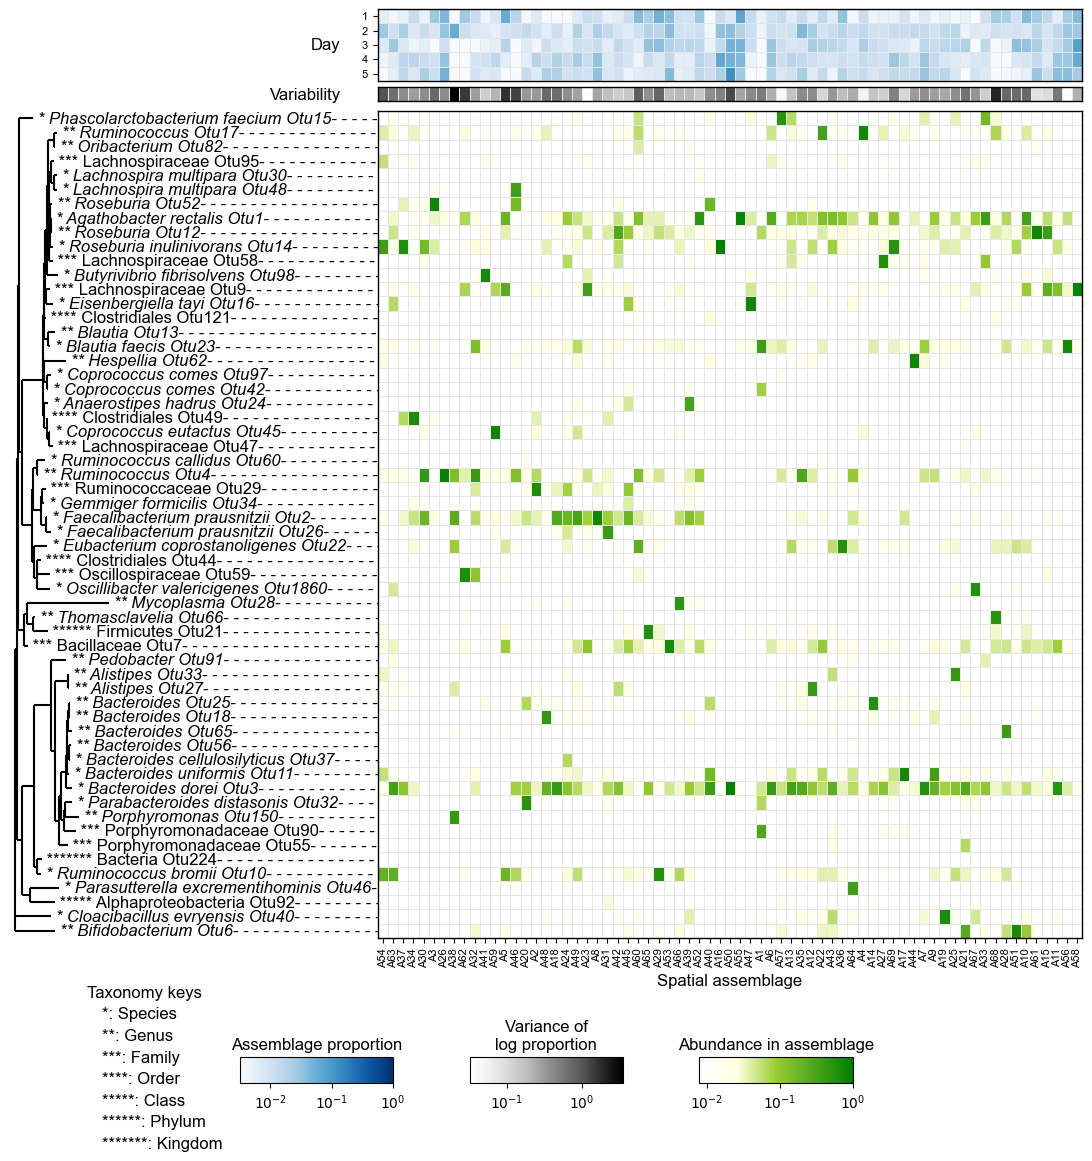

In [128]:
scale=2

labelpad = 15

lgd_ratio = 0.05
lgd_gap = 0.06

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max, 1/notu_max, notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max) - lgd_ratio - lgd_gap) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=6,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_var = fig.add_subplot(gs[1,2])
ax_tree = fig.add_subplot(gs[2,0])

# create subgridspecs to squish heatmaps and align tree to center
squish_ratio = 0.005
squish_hspace = 0
gs_theta = gs[2,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])


# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,5, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_var_lgd = fig.add_subplot(gs_lgd[0,2])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,3])

# PLOT =====================================================
# plot assemlage proportions
# beta_order = get_abundance_order(betadf)


ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order, vmin=-2.5)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=labelpad, ha='right', fontsize=fontsize, va='center')
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# plot variability
ax_var = sns.heatmap(np.log10(beta.loc[['Variance of log'], beta_order]), ax=ax_var, cmap=var_cmap, cbar=False,
                    linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=False,
                    norm=var_norm)
ax_var.set_ylabel("Variability", fontsize=fontsize, rotation = 0, labelpad=labelpad, ha='right', va='center')
ax_var.set_xlabel("")
ax_var = add_border(ax_var)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize, text_len=60)

# plot assemblages
thetadf2 = thetadf.copy()

# thetadf2[thetadf2<otu_threshold] = 0
ax_theta=plot_assemblages(ax_theta, thetadf2, otu_order, beta_order, cmap=theta_cmap, norm=theta_norm) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)
ax_theta.set_xlabel("Spatial assemblage", fontsize=fontsize)


# plot legend
norm = mpl.colors.Normalize(vmin=-2.5, vmax=0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0, -1,-2])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion", fontsize=fontsize)

# norm = mpl.colors.Normalize(vmin=-2, vmax=1)
ax_var_lgd=mpl.colorbar.ColorbarBase(ax_var_lgd, cmap=var_cmap, norm=var_norm, orientation='horizontal')
ax_var_lgd.ax.set_xticks([0,-1])
ax_var_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$'])
ax_var_lgd.ax.set_title("Variance of\nlog proportion")

norm = theta_norm
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Abundance in assemblage")



lgd_xpos=0.5
lgd_ypos=1.2+0.5
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

# align labels
fig.align_ylabels([ax_beta, ax_var])
plt.savefig(outpath / "human_full_results.png", bbox_inches="tight")

#### cluster columns instead?; how to order assemblages in best way?

In [56]:
logvar = np.log10(beta.loc["Variance of log",:]).values

In [57]:
print(np.amin(logvar))
print(np.median(logvar))
print(np.amax(logvar))

-1.4934076052218261
-0.4856412648090471
0.5448789613173565


In [58]:
 thetaflat = np.reshape(thetadf.values, (-1,))

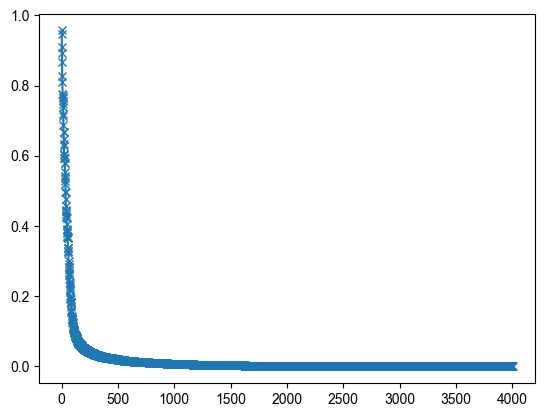

In [59]:
fig, ax = plt.subplots()
ax.plot(-np.sort(-thetaflat), '-x')

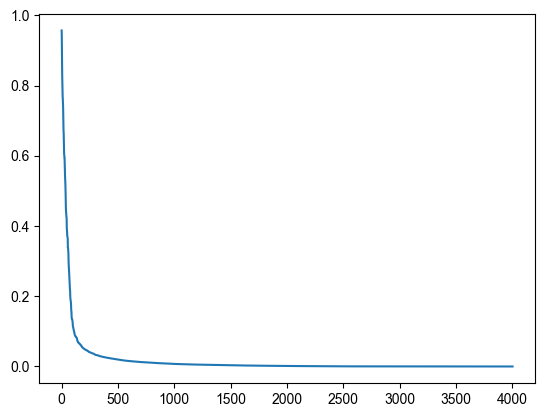

In [60]:
fig, ax = plt.subplots()
ax.plot(-np.sort(-thetaflat))

(0.0, 0.1)

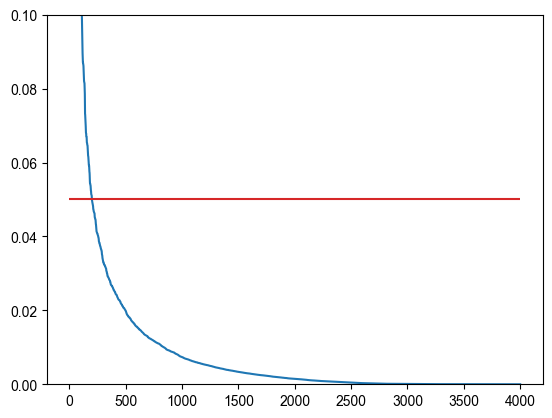

In [61]:
fig, ax = plt.subplots()
ax.plot(-np.sort(-thetaflat))
ax.hlines(0.05, 0, len(thetaflat), color='tab:red')
ax.set_ylim(0,0.1)

In [62]:
# fig, ax = plt.subplots()
# ax.plot(-np.sort(-thetaflat))
# ax.hlines(0.01, 0, len(thetaflat), color='tab:red')
# ax.set_ylim(0,0.1)
# ax.set_

(array([3889.,   34.,   16.,   14.,   13.,    7.,   12.,    7.,    5.,
           5.]),
 array([1.71466866e-07, 9.56779346e-02, 1.91355705e-01, 2.87033468e-01,
        3.82711232e-01, 4.78388995e-01, 5.74066758e-01, 6.69744492e-01,
        7.65422285e-01, 8.61100018e-01, 9.56777811e-01]),
 <BarContainer object of 10 artists>)

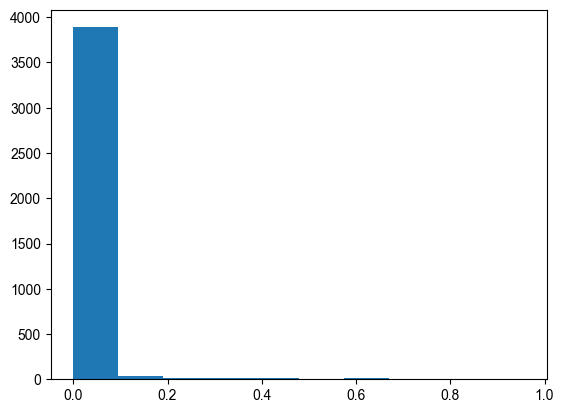

In [63]:
plt.hist(thetaflat)

In [64]:
np.percentile(thetaflat, q=95)

0.04991947375237937

In [65]:
np.percentile(thetaflat, q=50)

0.0014885813579894602

In [66]:
np.percentile(thetaflat, q=5)

6.7607274104375396e-06

# can use 0.05 for intepretation, but want to report all in heatmap

# try prob values and z-score criteria for filtering data

In [67]:
# thetadf

### compute usage probs

In [68]:
thetadf.head()

,,,,,,,,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69
Otu,Kingdom,Phylum,Class,Order,Family,Genus,Species,,,,,,,,,,,,,,,,,,,,,
Otu121,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na,0.000052,0.000014,0.000242,0.000437,1.781666e-06,0.001734,0.003279,0.000093,0.000574,0.004239,...,0.011149,0.000042,0.000004,7.585302e-05,0.002550,0.002987,0.001211,0.000604,0.021730,0.003368
Otu14,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans,0.005940,0.000244,0.041221,0.010959,5.553787e-06,0.012431,0.016941,0.016841,0.011932,0.010213,...,0.003474,0.002708,0.012941,1.539850e-02,0.013372,0.011733,0.034129,0.002216,0.008005,0.543192
Otu150,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,na,0.000012,0.000029,0.000016,0.000053,1.714669e-07,0.000009,0.000002,0.000103,0.000013,0.000035,...,0.000024,0.000037,0.000036,3.372271e-07,0.000025,0.001509,0.000070,0.000007,0.001506,0.000035
Otu37,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus,0.000149,0.000675,0.000004,0.000026,5.252889e-07,0.001403,0.003581,0.001785,0.009265,0.000269,...,0.000852,0.000032,0.004395,1.780347e-03,0.000019,0.000015,0.000966,0.000068,0.000111,0.000026
Otu6,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,na,0.002488,0.002598,0.000010,0.003122,2.498775e-02,0.001897,0.001975,0.000546,0.000764,0.094230,...,0.000474,0.012422,0.004437,9.384204e-04,0.001704,0.006746,0.026253,0.003690,0.000035,0.000870


In [69]:
avebeta

Assemblage,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,...,A63,A64,A65,A66,A67,A68,A69,A7,A8,A9
Time,,,,,,,,,,,,,,,,,,,,,
1,0.005059,0.038667,0.005746,0.005956,0.006132,0.004469,0.015021,0.012152,0.008859,0.002914,...,0.003820,0.003594,0.021543,0.010140,0.002687,0.024732,0.005000,0.007005,0.010584,0.004020
2,0.004458,0.007871,0.014884,0.023408,0.010758,0.010359,0.008145,0.033044,0.012041,0.011211,...,0.010414,0.011598,0.019040,0.010177,0.006965,0.010801,0.012377,0.013916,0.021357,0.010281
3,0.002134,0.031895,0.013156,0.023314,0.008020,0.011524,0.008605,0.013971,0.006989,0.007263,...,0.028289,0.008047,0.032390,0.015907,0.002613,0.003518,0.007365,0.015661,0.012205,0.011976
4,0.002479,0.008417,0.029185,0.010999,0.017430,0.010845,0.006790,0.065234,0.015950,0.019785,...,0.006679,0.009486,0.012033,0.006041,0.007617,0.000926,0.028310,0.029191,0.032954,0.014515
5,0.000875,0.005465,0.037263,0.006474,0.010001,0.008290,0.011221,0.021790,0.012485,0.020045,...,0.005686,0.011136,0.006997,0.005289,0.009562,0.001263,0.014691,0.031256,0.034153,0.013979


In [70]:
t = thetadf.values
b = avebeta.loc[:,thetadf.columns].values
print(t.shape)
print(b.shape)

(58, 69)
(5, 69)


In [71]:
btave = np.mean(b,axis=0)
print(btave.shape)

(69,)


In [72]:
usage = (t*btave)/np.sum(t*btave, axis=1, keepdims=True)

In [73]:
usage.shape

(58, 69)

In [74]:
print(usage.sum(axis=1))
print(len(usage.sum(axis=1)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
58


In [75]:
ncomm = t.shape[1]
print(ncomm)

69


In [76]:
randprob = 1.0/ncomm
print(randprob)

0.014492753623188406


In [77]:
print(usage.shape[0]*usage.shape[1])
print((usage>randprob).sum())

4002
668


In [78]:
usage.shape

(58, 69)

In [79]:
thetadf_psparse = thetadf.copy()
thetadf_psparse[usage<randprob] = 0

In [80]:
# thetadf

original tree size: 3923
pruned tree size: 58


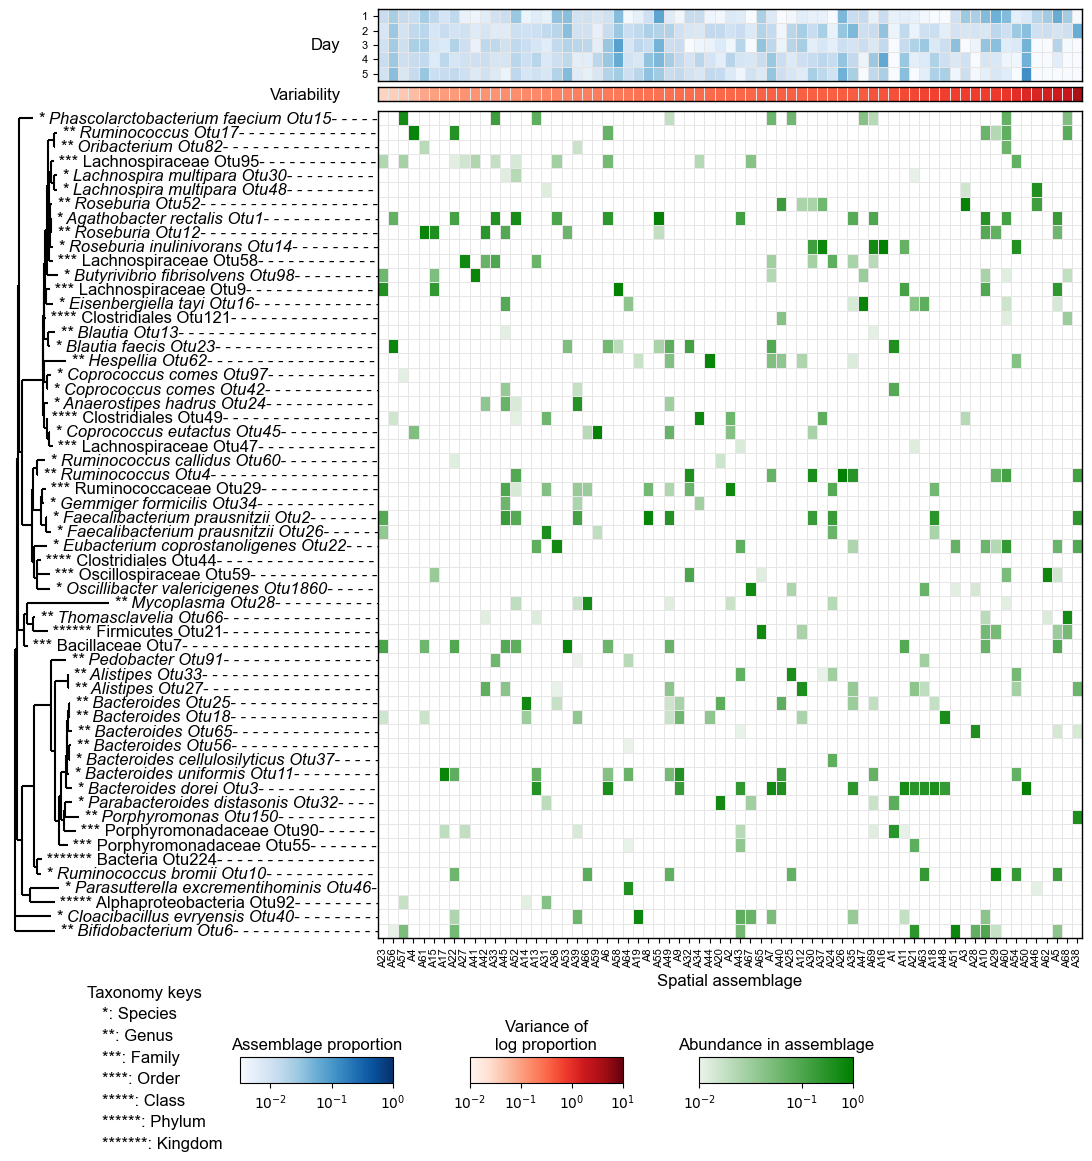

In [81]:
scale=2

labelpad = 15

lgd_ratio = 0.05
lgd_gap = 0.06

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max, 1/notu_max, notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max) - lgd_ratio - lgd_gap) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=6,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_var = fig.add_subplot(gs[1,2])
ax_tree = fig.add_subplot(gs[2,0])

# create subgridspecs to squish heatmaps and align tree to center
squish_ratio = 0.005
squish_hspace = 0
gs_theta = gs[2,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])


# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,5, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_var_lgd = fig.add_subplot(gs_lgd[0,2])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,3])

# PLOT =====================================================
# plot assemlage proportions
# beta_order = get_abundance_order(betadf)
beta_order = beta.T.sort_values(by="Variance of log").index

ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order, vmin=-2.5)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=labelpad, ha='right', fontsize=fontsize, va='center')
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# plot variability
ax_var = sns.heatmap(np.log10(beta.loc[['Variance of log'], beta_order]), ax=ax_var, cmap='Reds', cbar=False,
                    linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=False,
                    vmin=-2, vmax=1)
ax_var.set_ylabel("Variability", fontsize=fontsize, rotation = 0, labelpad=labelpad, ha='right', va='center')
ax_var.set_xlabel("")
ax_var = add_border(ax_var)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize, text_len=60)

# plot assemblages
thetadf2 = thetadf_psparse.copy()

# thetadf2[thetadf2<otu_threshold] = 0
ax_theta=plot_assemblages(ax_theta, thetadf2, otu_order, beta_order, cmap=theta_cmap, norm=theta_norm) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)
ax_theta.set_xlabel("Spatial assemblage", fontsize=fontsize)


# plot legend
norm = mpl.colors.Normalize(vmin=-2.5, vmax=0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0, -1,-2])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion", fontsize=fontsize)

norm = mpl.colors.Normalize(vmin=-2, vmax=1)
ax_var_lgd=mpl.colorbar.ColorbarBase(ax_var_lgd, cmap="Reds", norm=norm, orientation='horizontal')
ax_var_lgd.ax.set_xticks([1, 0,-1,-2])
ax_var_lgd.ax.set_xticklabels([r'$10^{1}$',r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_var_lgd.ax.set_title("Variance of\nlog proportion")

norm = theta_norm
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Abundance in assemblage")



lgd_xpos=0.5
lgd_ypos=1.2+0.5
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

# align labels
fig.align_ylabels([ax_beta, ax_var])
plt.savefig(outpath / "human_full_results_prob_sparse.png", bbox_inches="tight")

In [82]:
# thetadf

In [83]:
# thetadf

In [84]:
print((thetadf.values>0.01).sum())
print((thetadf_psparse.values>0).sum())
print((thetadf.values>0.01).sum() - (thetadf_psparse.values>0).sum())

838
668
170


In [85]:
print((thetadf.values>0.05).sum())
print((thetadf_psparse.values>0).sum())
print((thetadf.values>0.05).sum() - (thetadf_psparse.values>0).sum())

200
668
-468


## try with z-scores

In [86]:
t.shape

(58, 69)

In [87]:
z = (t - np.mean(t,axis=1,keepdims=True))/(np.std(t, axis=1, keepdims=True))

In [88]:
z.shape

(58, 69)

In [89]:
print((z>2).sum())
print((z>3).sum())

120
77


In [90]:
# z

In [91]:
theta_zsparse2 = thetadf.copy()
theta_zsparse3 = thetadf.copy()

theta_zsparse2[z<2] = 0
theta_zsparse3[z<3] = 0


In [92]:
theta_zsparse0 = thetadf.copy()
theta_zsparse0[z<0] = 0

In [93]:
print((z>0).sum())

648


original tree size: 3923
pruned tree size: 58


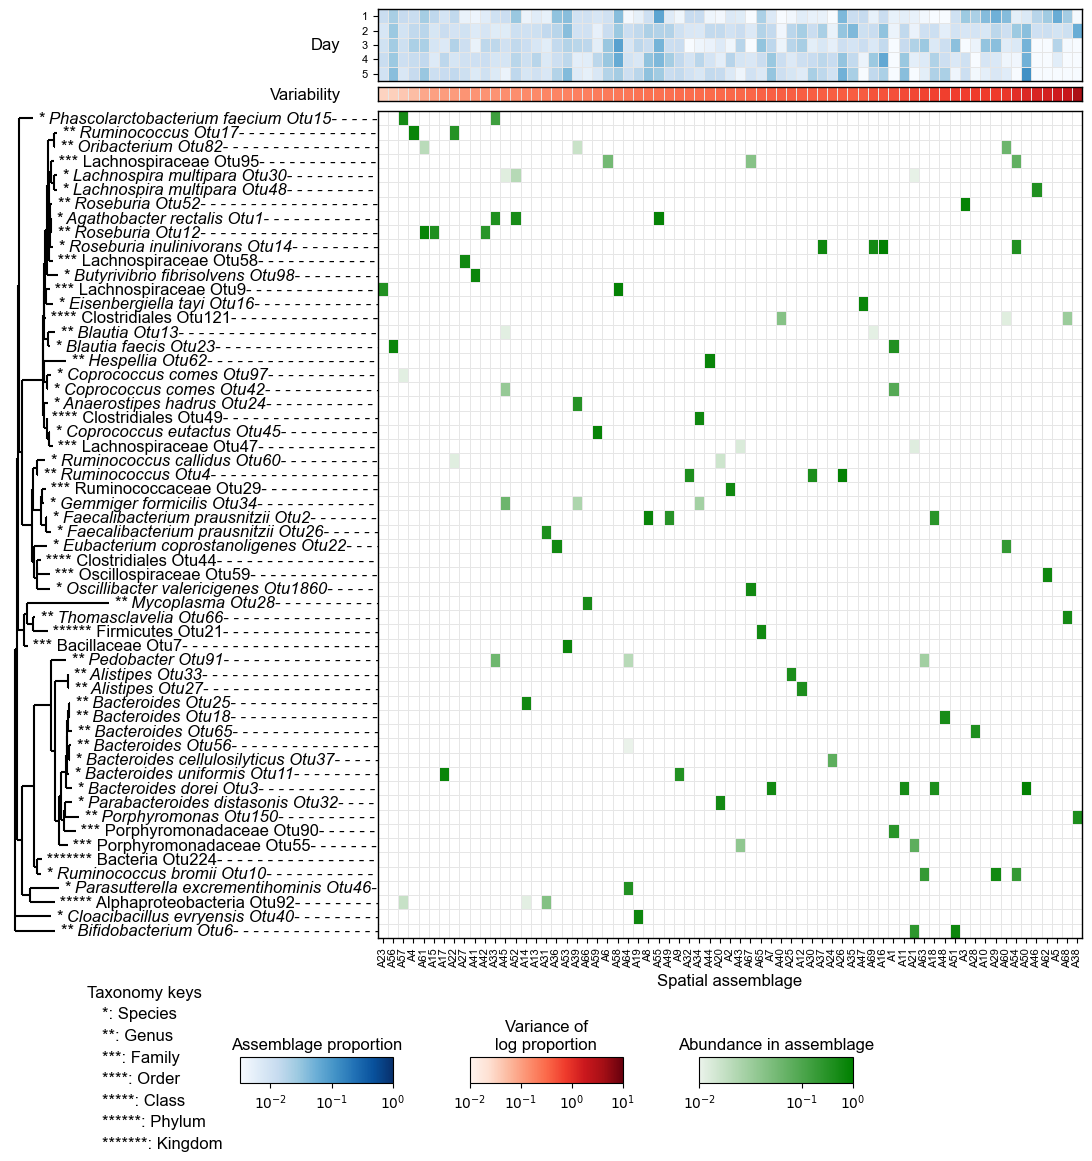

In [94]:
scale=2

labelpad = 15

lgd_ratio = 0.05
lgd_gap = 0.06

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max, 1/notu_max, notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max) - lgd_ratio - lgd_gap) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=6,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_var = fig.add_subplot(gs[1,2])
ax_tree = fig.add_subplot(gs[2,0])

# create subgridspecs to squish heatmaps and align tree to center
squish_ratio = 0.005
squish_hspace = 0
gs_theta = gs[2,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])


# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,5, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_var_lgd = fig.add_subplot(gs_lgd[0,2])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,3])

# PLOT =====================================================
# plot assemlage proportions
# beta_order = get_abundance_order(betadf)
beta_order = beta.T.sort_values(by="Variance of log").index

ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order, vmin=-2.5)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=labelpad, ha='right', fontsize=fontsize, va='center')
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# plot variability
ax_var = sns.heatmap(np.log10(beta.loc[['Variance of log'], beta_order]), ax=ax_var, cmap='Reds', cbar=False,
                    linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=False,
                    vmin=-2, vmax=1)
ax_var.set_ylabel("Variability", fontsize=fontsize, rotation = 0, labelpad=labelpad, ha='right', va='center')
ax_var.set_xlabel("")
ax_var = add_border(ax_var)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize, text_len=60)

# plot assemblages
thetadf2 = theta_zsparse2.copy()

# thetadf2[thetadf2<otu_threshold] = 0
ax_theta=plot_assemblages(ax_theta, thetadf2, otu_order, beta_order, cmap=theta_cmap, norm=theta_norm) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)
ax_theta.set_xlabel("Spatial assemblage", fontsize=fontsize)


# plot legend
norm = mpl.colors.Normalize(vmin=-2.5, vmax=0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0, -1,-2])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion", fontsize=fontsize)

norm = mpl.colors.Normalize(vmin=-2, vmax=1)
ax_var_lgd=mpl.colorbar.ColorbarBase(ax_var_lgd, cmap="Reds", norm=norm, orientation='horizontal')
ax_var_lgd.ax.set_xticks([1, 0,-1,-2])
ax_var_lgd.ax.set_xticklabels([r'$10^{1}$',r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_var_lgd.ax.set_title("Variance of\nlog proportion")

norm = theta_norm
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Abundance in assemblage")



lgd_xpos=0.5
lgd_ypos=1.2+0.5
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

# align labels
fig.align_ylabels([ax_beta, ax_var])
plt.savefig(outpath / "human_full_results_cutoff_zscore2.png", bbox_inches="tight")

original tree size: 3923
pruned tree size: 58


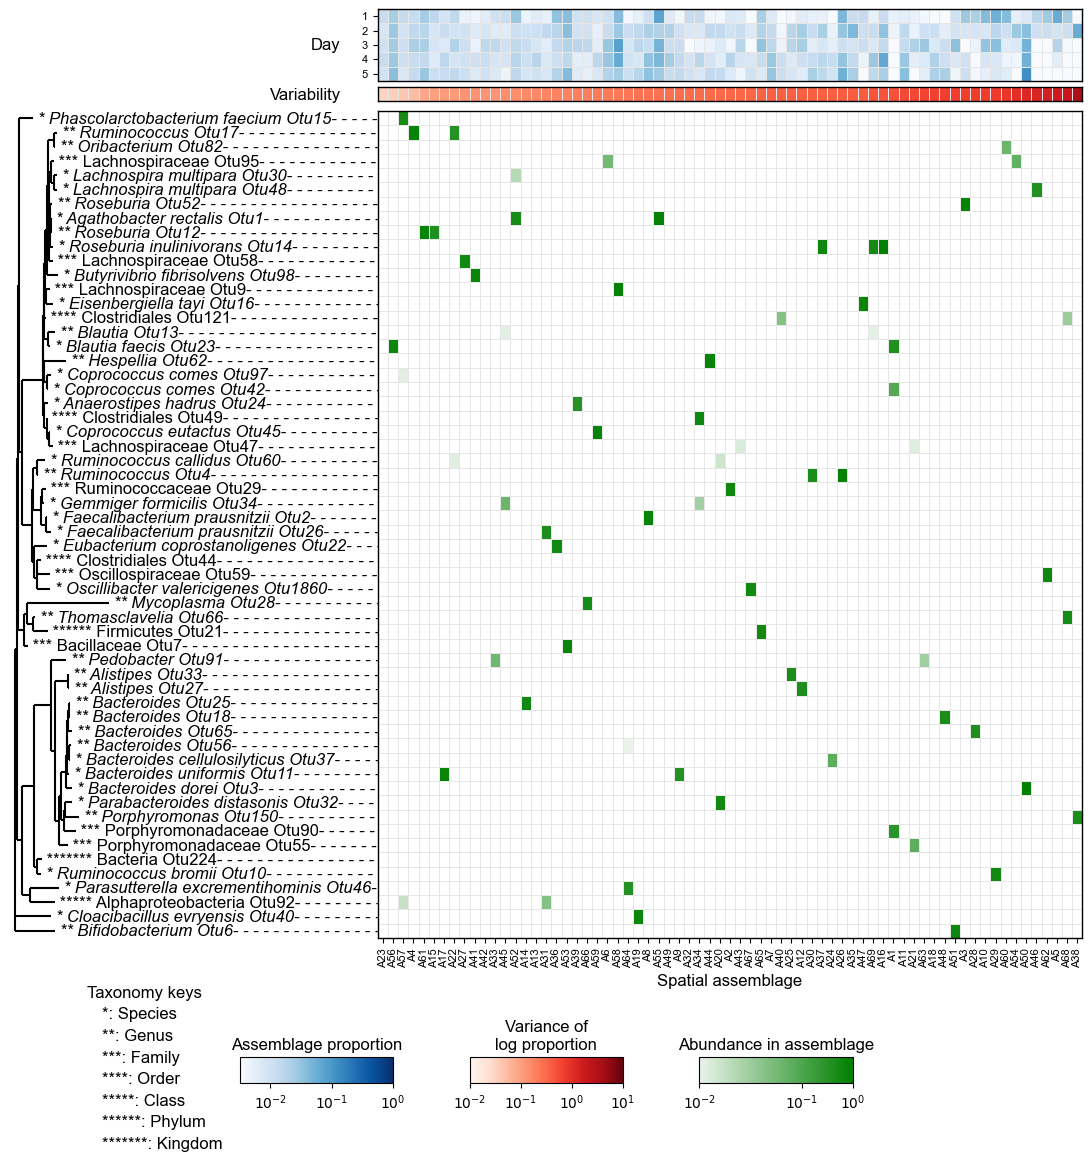

In [95]:
scale=2

labelpad = 15

lgd_ratio = 0.05
lgd_gap = 0.06

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max, 1/notu_max, notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max) - lgd_ratio - lgd_gap) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=6,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_var = fig.add_subplot(gs[1,2])
ax_tree = fig.add_subplot(gs[2,0])

# create subgridspecs to squish heatmaps and align tree to center
squish_ratio = 0.005
squish_hspace = 0
gs_theta = gs[2,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])


# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,5, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_var_lgd = fig.add_subplot(gs_lgd[0,2])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,3])

# PLOT =====================================================
# plot assemlage proportions
# beta_order = get_abundance_order(betadf)
beta_order = beta.T.sort_values(by="Variance of log").index

ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order, vmin=-2.5)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=labelpad, ha='right', fontsize=fontsize, va='center')
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# plot variability
ax_var = sns.heatmap(np.log10(beta.loc[['Variance of log'], beta_order]), ax=ax_var, cmap='Reds', cbar=False,
                    linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=False,
                    vmin=-2, vmax=1)
ax_var.set_ylabel("Variability", fontsize=fontsize, rotation = 0, labelpad=labelpad, ha='right', va='center')
ax_var.set_xlabel("")
ax_var = add_border(ax_var)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize, text_len=60)

# plot assemblages
thetadf2 = theta_zsparse3.copy()

# thetadf2[thetadf2<otu_threshold] = 0
ax_theta=plot_assemblages(ax_theta, thetadf2, otu_order, beta_order, cmap=theta_cmap, norm=theta_norm) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)
ax_theta.set_xlabel("Spatial assemblage", fontsize=fontsize)


# plot legend
norm = mpl.colors.Normalize(vmin=-2.5, vmax=0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0, -1,-2])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion", fontsize=fontsize)

norm = mpl.colors.Normalize(vmin=-2, vmax=1)
ax_var_lgd=mpl.colorbar.ColorbarBase(ax_var_lgd, cmap="Reds", norm=norm, orientation='horizontal')
ax_var_lgd.ax.set_xticks([1, 0,-1,-2])
ax_var_lgd.ax.set_xticklabels([r'$10^{1}$',r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_var_lgd.ax.set_title("Variance of\nlog proportion")

norm = theta_norm
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Abundance in assemblage")



lgd_xpos=0.5
lgd_ypos=1.2+0.5
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

# align labels
fig.align_ylabels([ax_beta, ax_var])
plt.savefig(outpath / "human_full_results_cutoff_zscore3.png", bbox_inches="tight")

# output csv files

In [96]:
usage.shape

(58, 69)

In [97]:
usagedf = pd.DataFrame(usage, index=thetadf.index, columns=thetadf.columns)
zscoredf = pd.DataFrame(z, index=thetadf.index, columns=thetadf.columns)

In [98]:
thetadf_psparse.to_csv(outpath / "assemblages_prob_cutoff.csv")
theta_zsparse2.to_csv(outpath / "assemblages_cutoff_zscore2.csv")
theta_zsparse3.to_csv(outpath / "assemblages_cutoff_zscore3.csv")

usagedf.to_csv(outpath / "otu_assemblage_probabilities.csv")
zscoredf.to_csv(outpath / "zscores.csv")

In [99]:
outpath

WindowsPath('figs_human_results')